# Compiler-Based Graph Representations for Deep Learning Models of Code

This document contains the artifact of the paper "Compiler-Based Graph Representations for Deep Learning Models of Code", submitted to ACM SIGPLAN 2020 International Conference on Compiler Construction (CC 2020).

## Table of contents
1. [Compiler-Based Graph Representations](#representations)
    1. [Abstract Syntax-Tree](#ast)
    2. [Control- and Dataflow Graph](#cdfg)
2. [Evaluation Tasks](#eval)
    1. [CPU/GPU Mapping](#devmap)
        1. [Building the dataset](#devmap-data)
        2. [Training and Predicting](#devmap-train)
        3. [Evaluation](#devmap-predict)
    2. [Thread Coarsening](#tc)
        1. [Building the dataset](#tc-data)
        2. [Training and Predicting](#tc-train)
        3. [Evaluation](#tc-predict)
3. [References](#refs)

In [1]:
import json
import warnings

import preamble

import lib.experiment.DevMapExperiment as DevMapExperiment
import lib.experiment.ThreadCoarsenExperiment as ThreadCoarsenExperiment

warnings.filterwarnings('ignore')

In [2]:
library(readr)
library(tidyverse)
#library(ggforce)
library(scales)
library("RColorBrewer")

Warning message:
“replacing previous import by ‘rlang:::=’ when loading ‘dplyr’”
Warning message:
“replacing previous import by ‘rlang::.data’ when loading ‘dplyr’”
Warning message:
“replacing previous import by ‘rlang::as_label’ when loading ‘dplyr’”
Warning message:
“replacing previous import by ‘rlang::as_name’ when loading ‘dplyr’”
Warning message:
“replacing previous import by ‘rlang::dots_n’ when loading ‘dplyr’”
Warning message:
“replacing previous import by ‘rlang::enquo’ when loading ‘dplyr’”
Warning message:
“replacing previous import by ‘rlang::enquos’ when loading ‘dplyr’”
Warning message:
“replacing previous import by ‘rlang::expr’ when loading ‘dplyr’”
Warning message:
“replacing previous import by ‘rlang::sym’ when loading ‘dplyr’”
Warning message:
“replacing previous import by ‘rlang::syms’ when loading ‘dplyr’”
Warning message:
“replacing previous import by ‘tibble::as_tibble’ when loading ‘broom’”
Warning message:
“replacing previous import by ‘tibble::tibble’ when lo

In [3]:
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

## Compiler-Based Graph Representations<a name="representations"></a>

For introducing and explaining the graph-based representations, we define several example programs in C and extract the AST and CDFG representations using our developed Clang- and LLVM-based tools and preprocessing steps.

The example programs are simple, yet functional algorithms to solve practical problems. They contain the main control structures of the C programming language, as well as complex dataflow structures. We believe this to be better suited for illustration purposes than the benchmarks to be used later. However, the functions can easily be applied to visualize the benchmark programs the same way using this notebook.

In [4]:
example1 = """
int isPrime(int n) {
     if (n <= 1) return 0;
     if (n % 2 == 0 && n > 2) return 0;
     for(int i = 3; i < n / 2; i += 2) {
         if (n % i == 0)
             return 0;
     }
     return 1;
}
"""

example2 = """
int fibbonacci(int n) {
   if(n == 0) {
      return 0;
   } else if(n == 1) {
      return 1;
   } else {
      return (fibbonacci(n-1) + fibbonacci(n-2));
   }
}
"""

example3 = """
int isPalindrome(int* str, int size) {
    int l = 0;
    int h = size;

    while (h > l) {
        if (str[l++] != str[h--]) {
            return 0;
        }
    }
    return 1;
} 
"""

example4 = """
void insertionSort(int* arr, int n) {  
    int i, key, j;
    for (i = 1; i < n; i++) {  
        key = arr[i];  
        j = i - 1;  
  
        while (j >= 0 && arr[j] > key) {  
            arr[j + 1] = arr[j];
            j = j - 1;
        }
        arr[j + 1] = key;
    }
}
"""

### Abstract Syntax-Tree <a name="ast"></a>

The AST-based representation is constructed by extracting the Clang AST from C code, then eliminating several node types.

Note: Graphs can be enlarged with double-click.

,

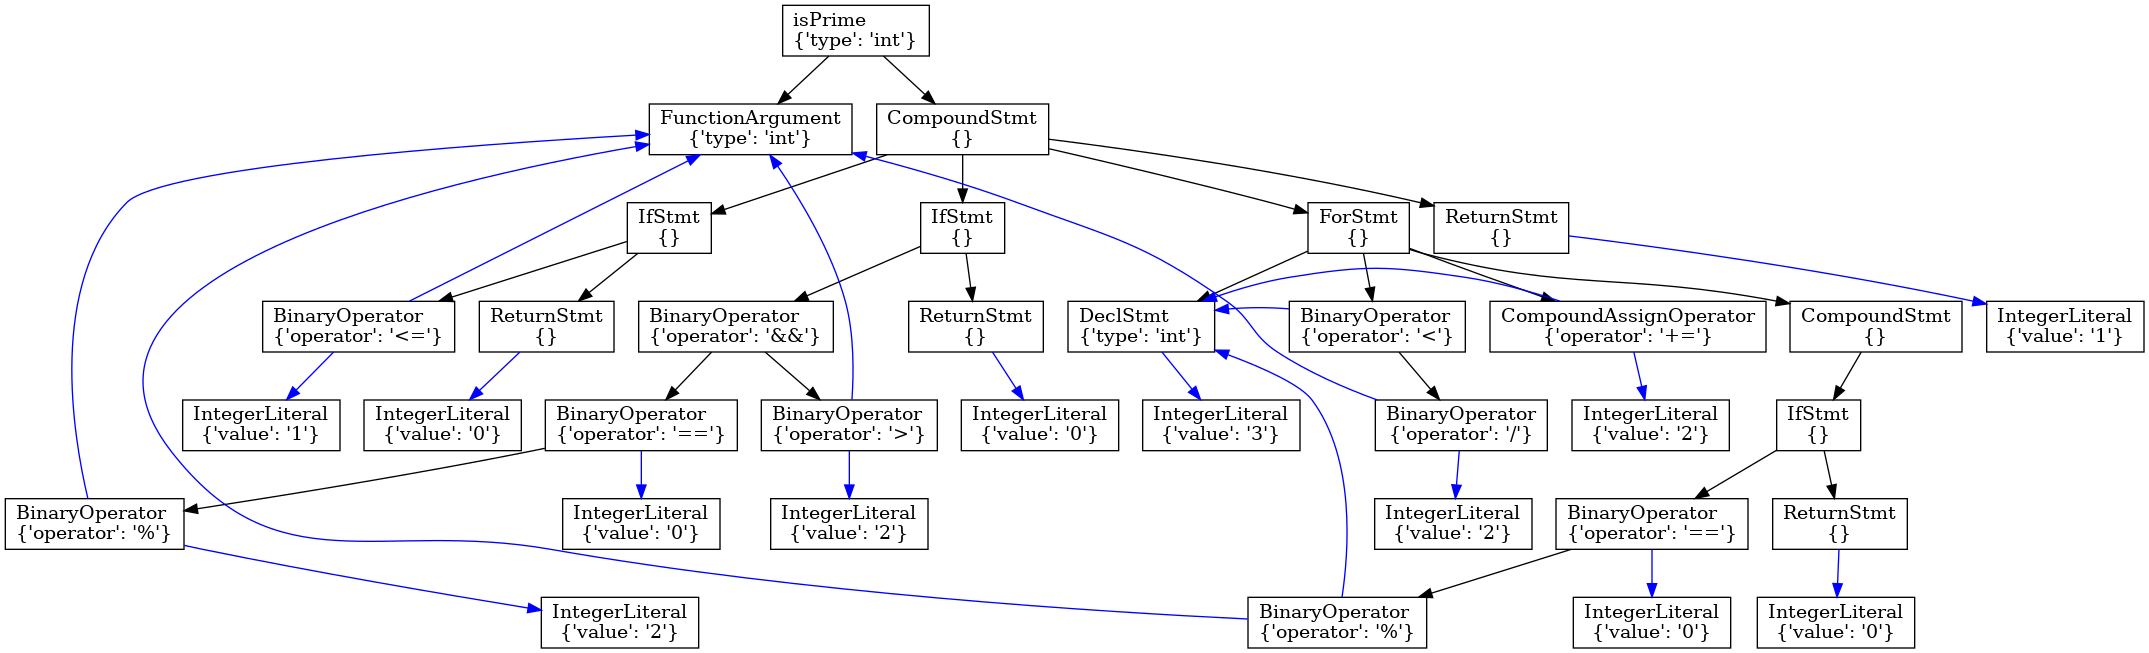
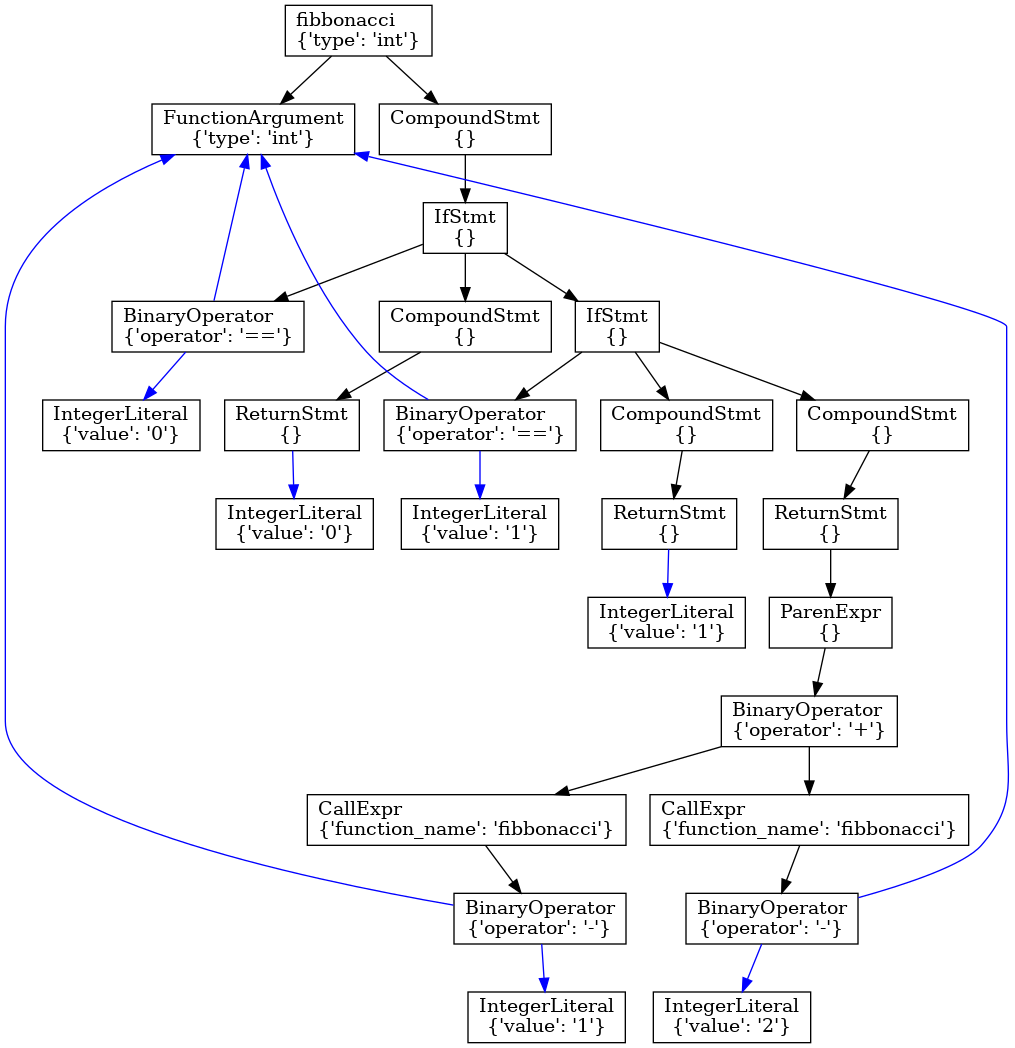

,

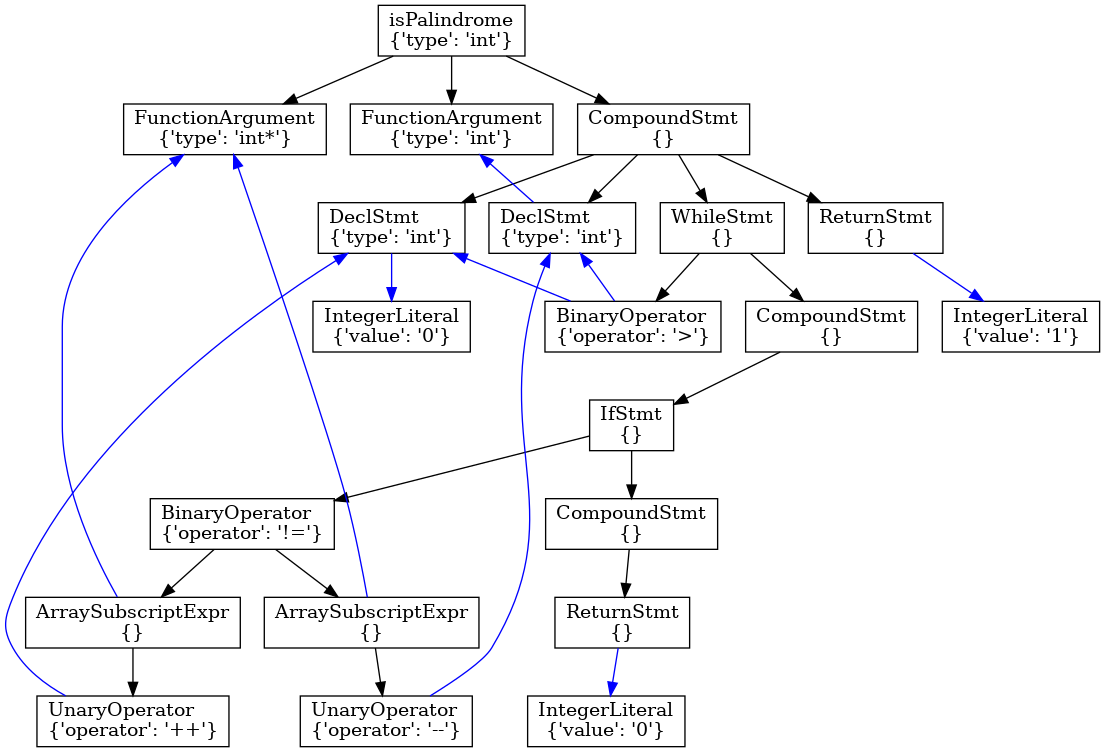
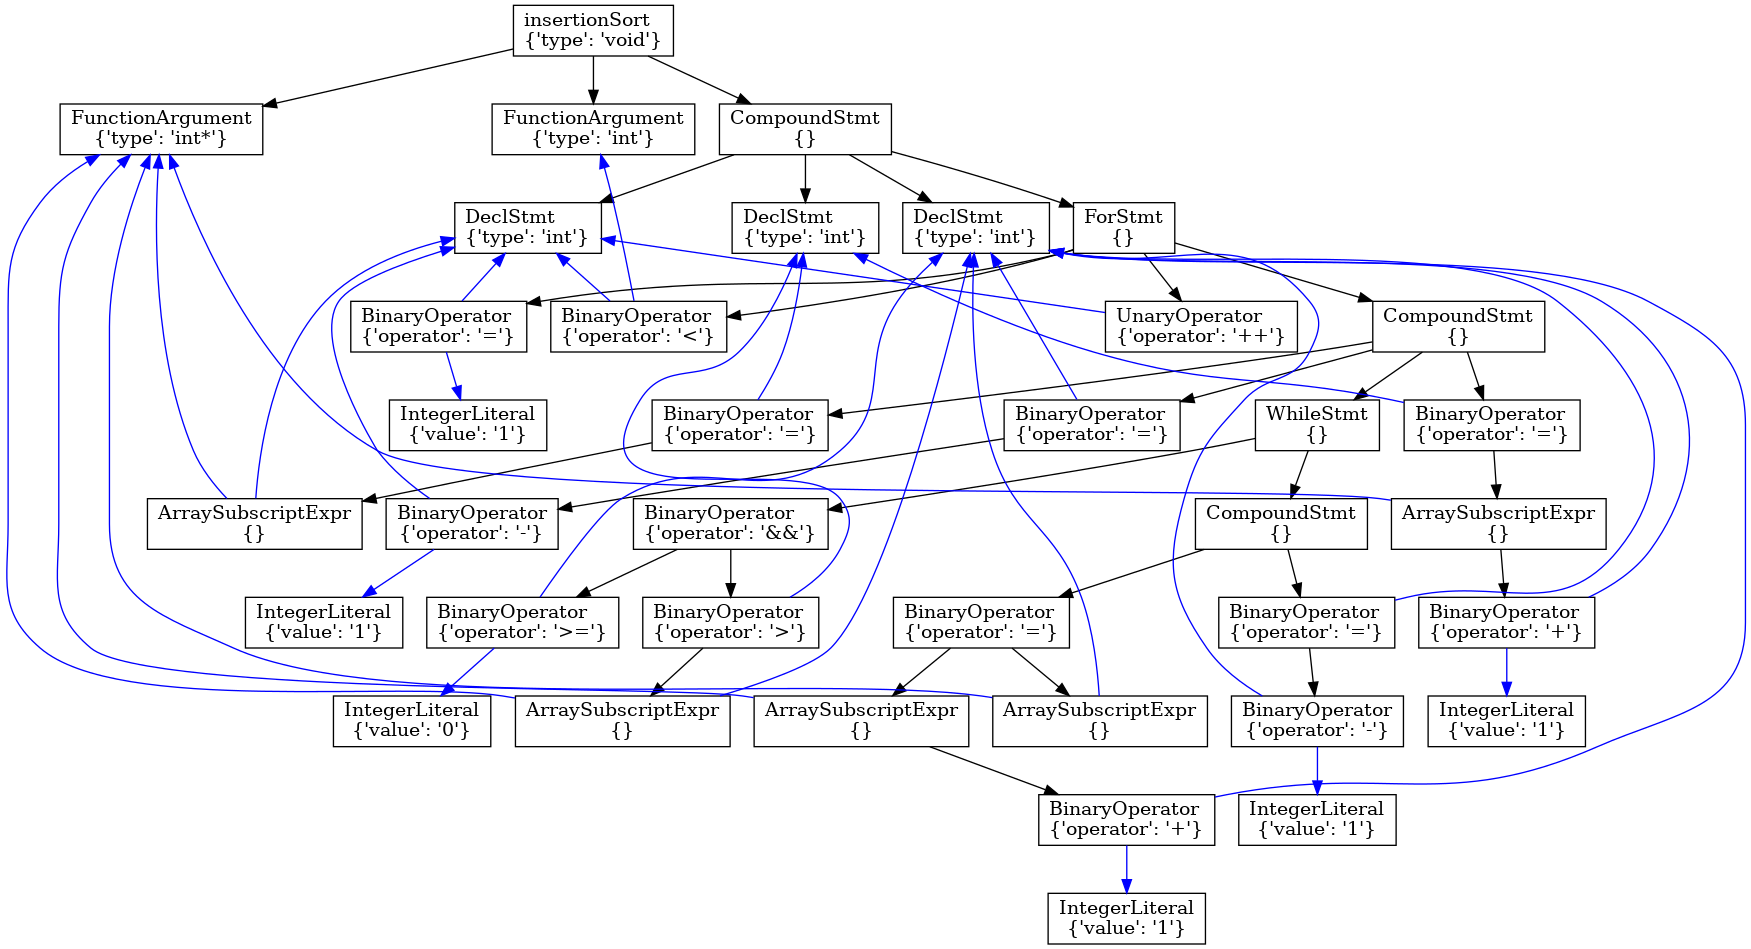

In [5]:
import lib.representations.clang.codegraph_models as clang_codegraph_models
import lib.representations.clang.preprocess as clang_preprocess
    
def gen_ast(src):
    # Extract Clang graphs from C code
    miner_output = clang_preprocess.process_source_buffer(src)[0]
    # Parse AST graph
    graph = clang_codegraph_models.codegraphs_create_from_miner_output(json.loads(miner_output))[0]
    # Transform AST graph
    graph = clang_codegraph_models.transform_graph(graph)

    dot_graph = clang_codegraph_models.make_dot_graph(graph)
    return dot_graph.dot

preamble.view_dots([gen_ast(example1), gen_ast(example2)])
preamble.view_dots([gen_ast(example3), gen_ast(example4)])

### Control- and Dataflow Graph <a name="cdfg"></a>


Note: Graphs can be enlarged with double-click.

,

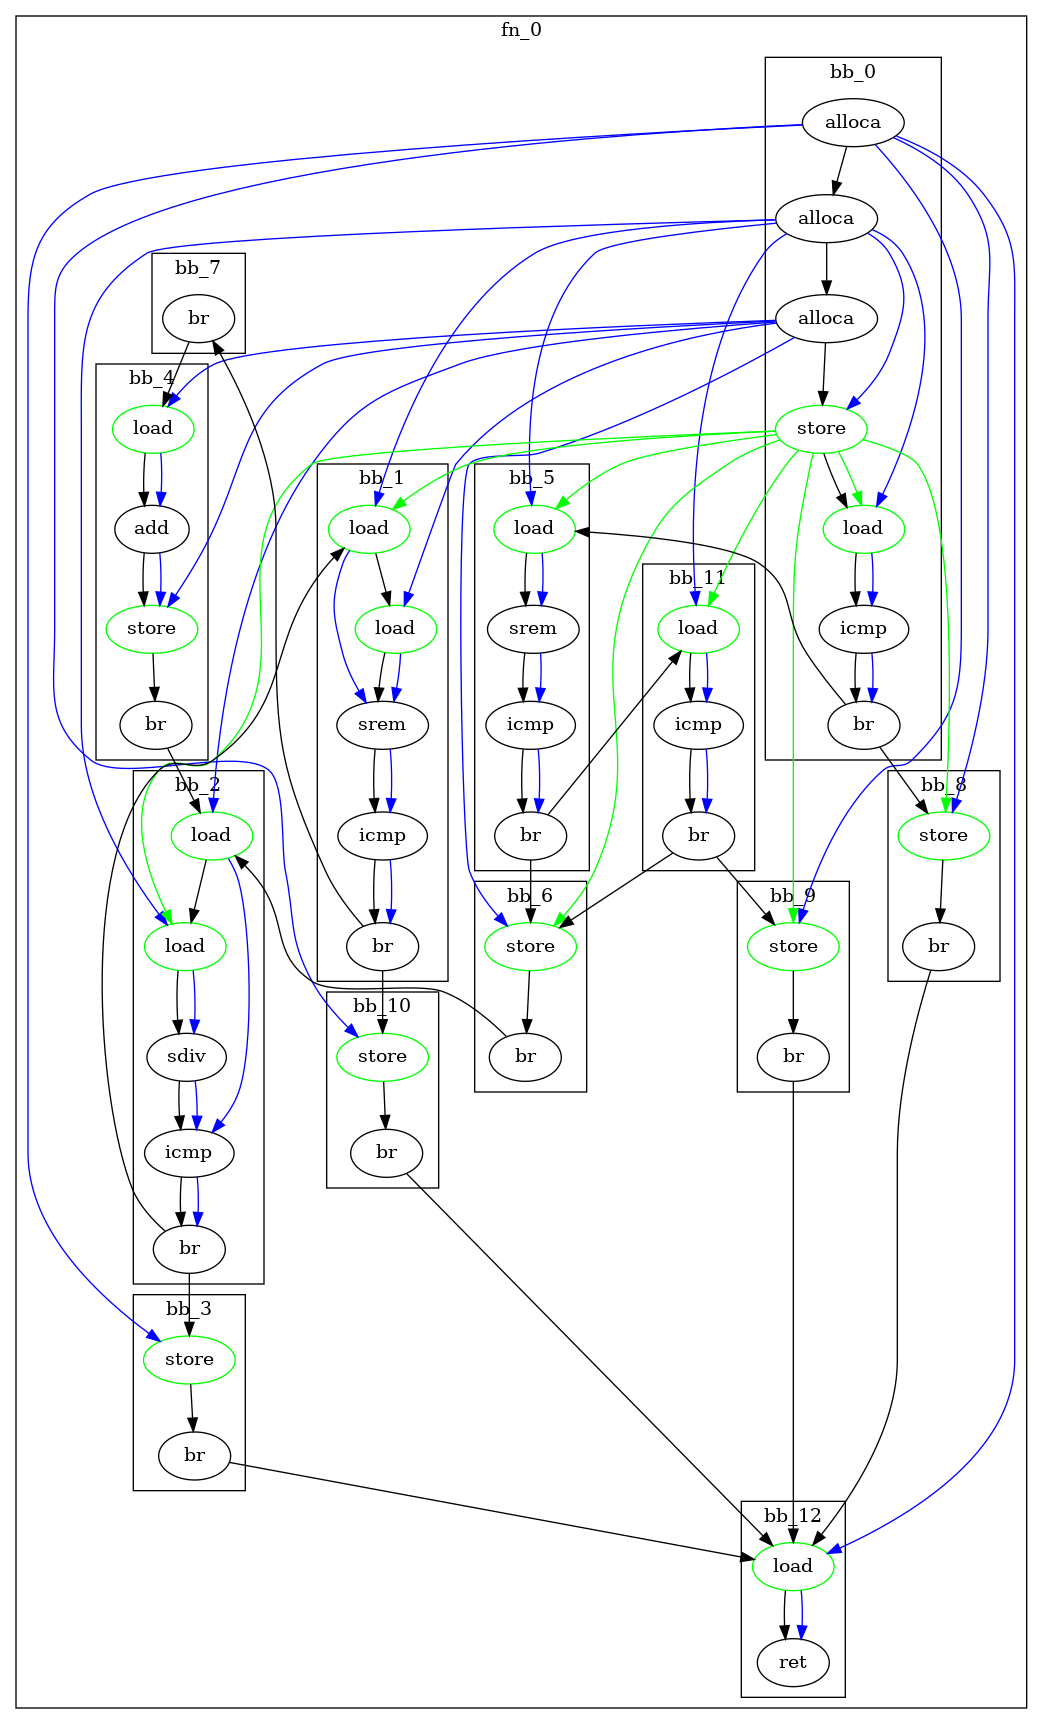
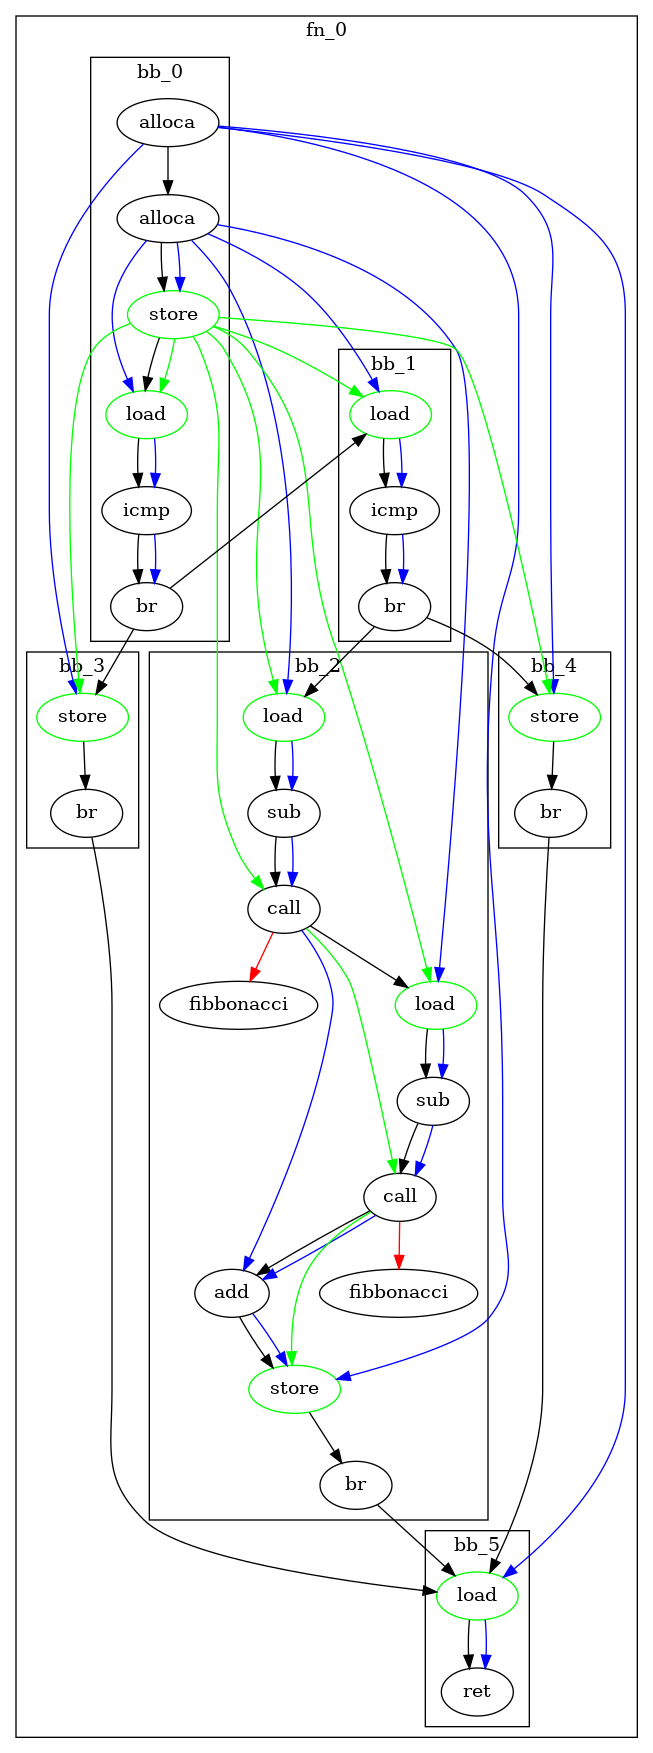

,

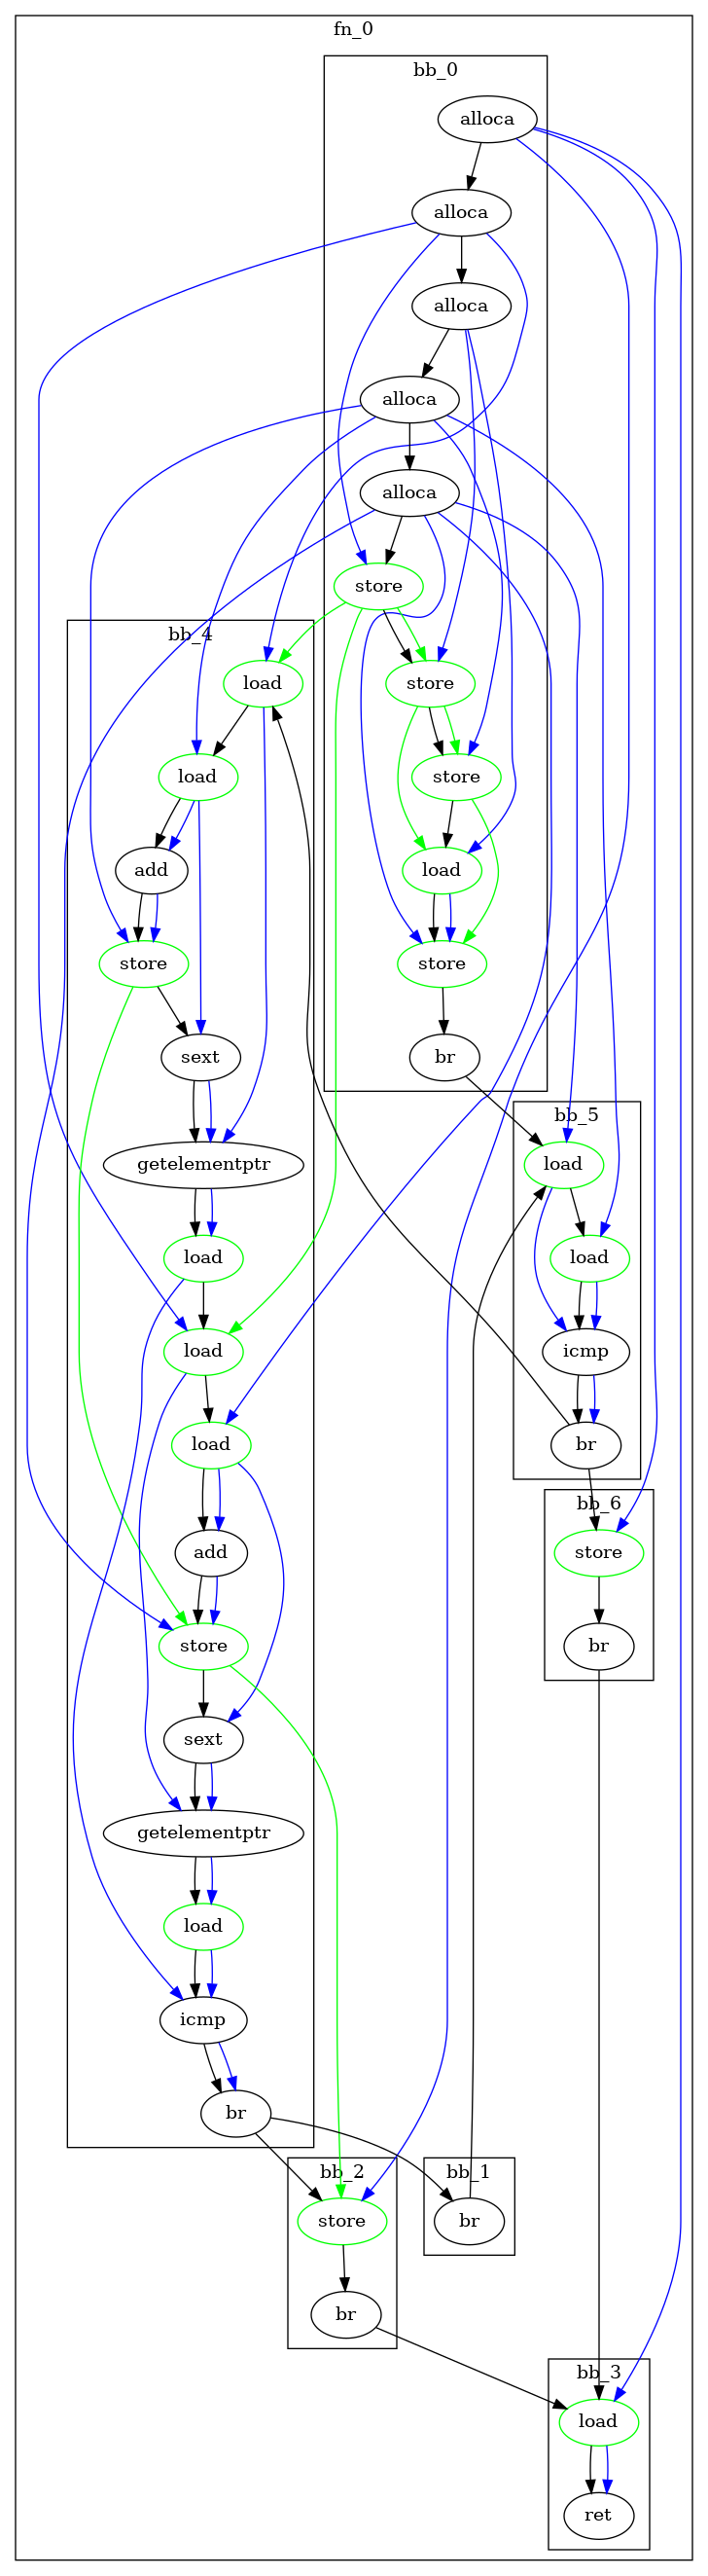
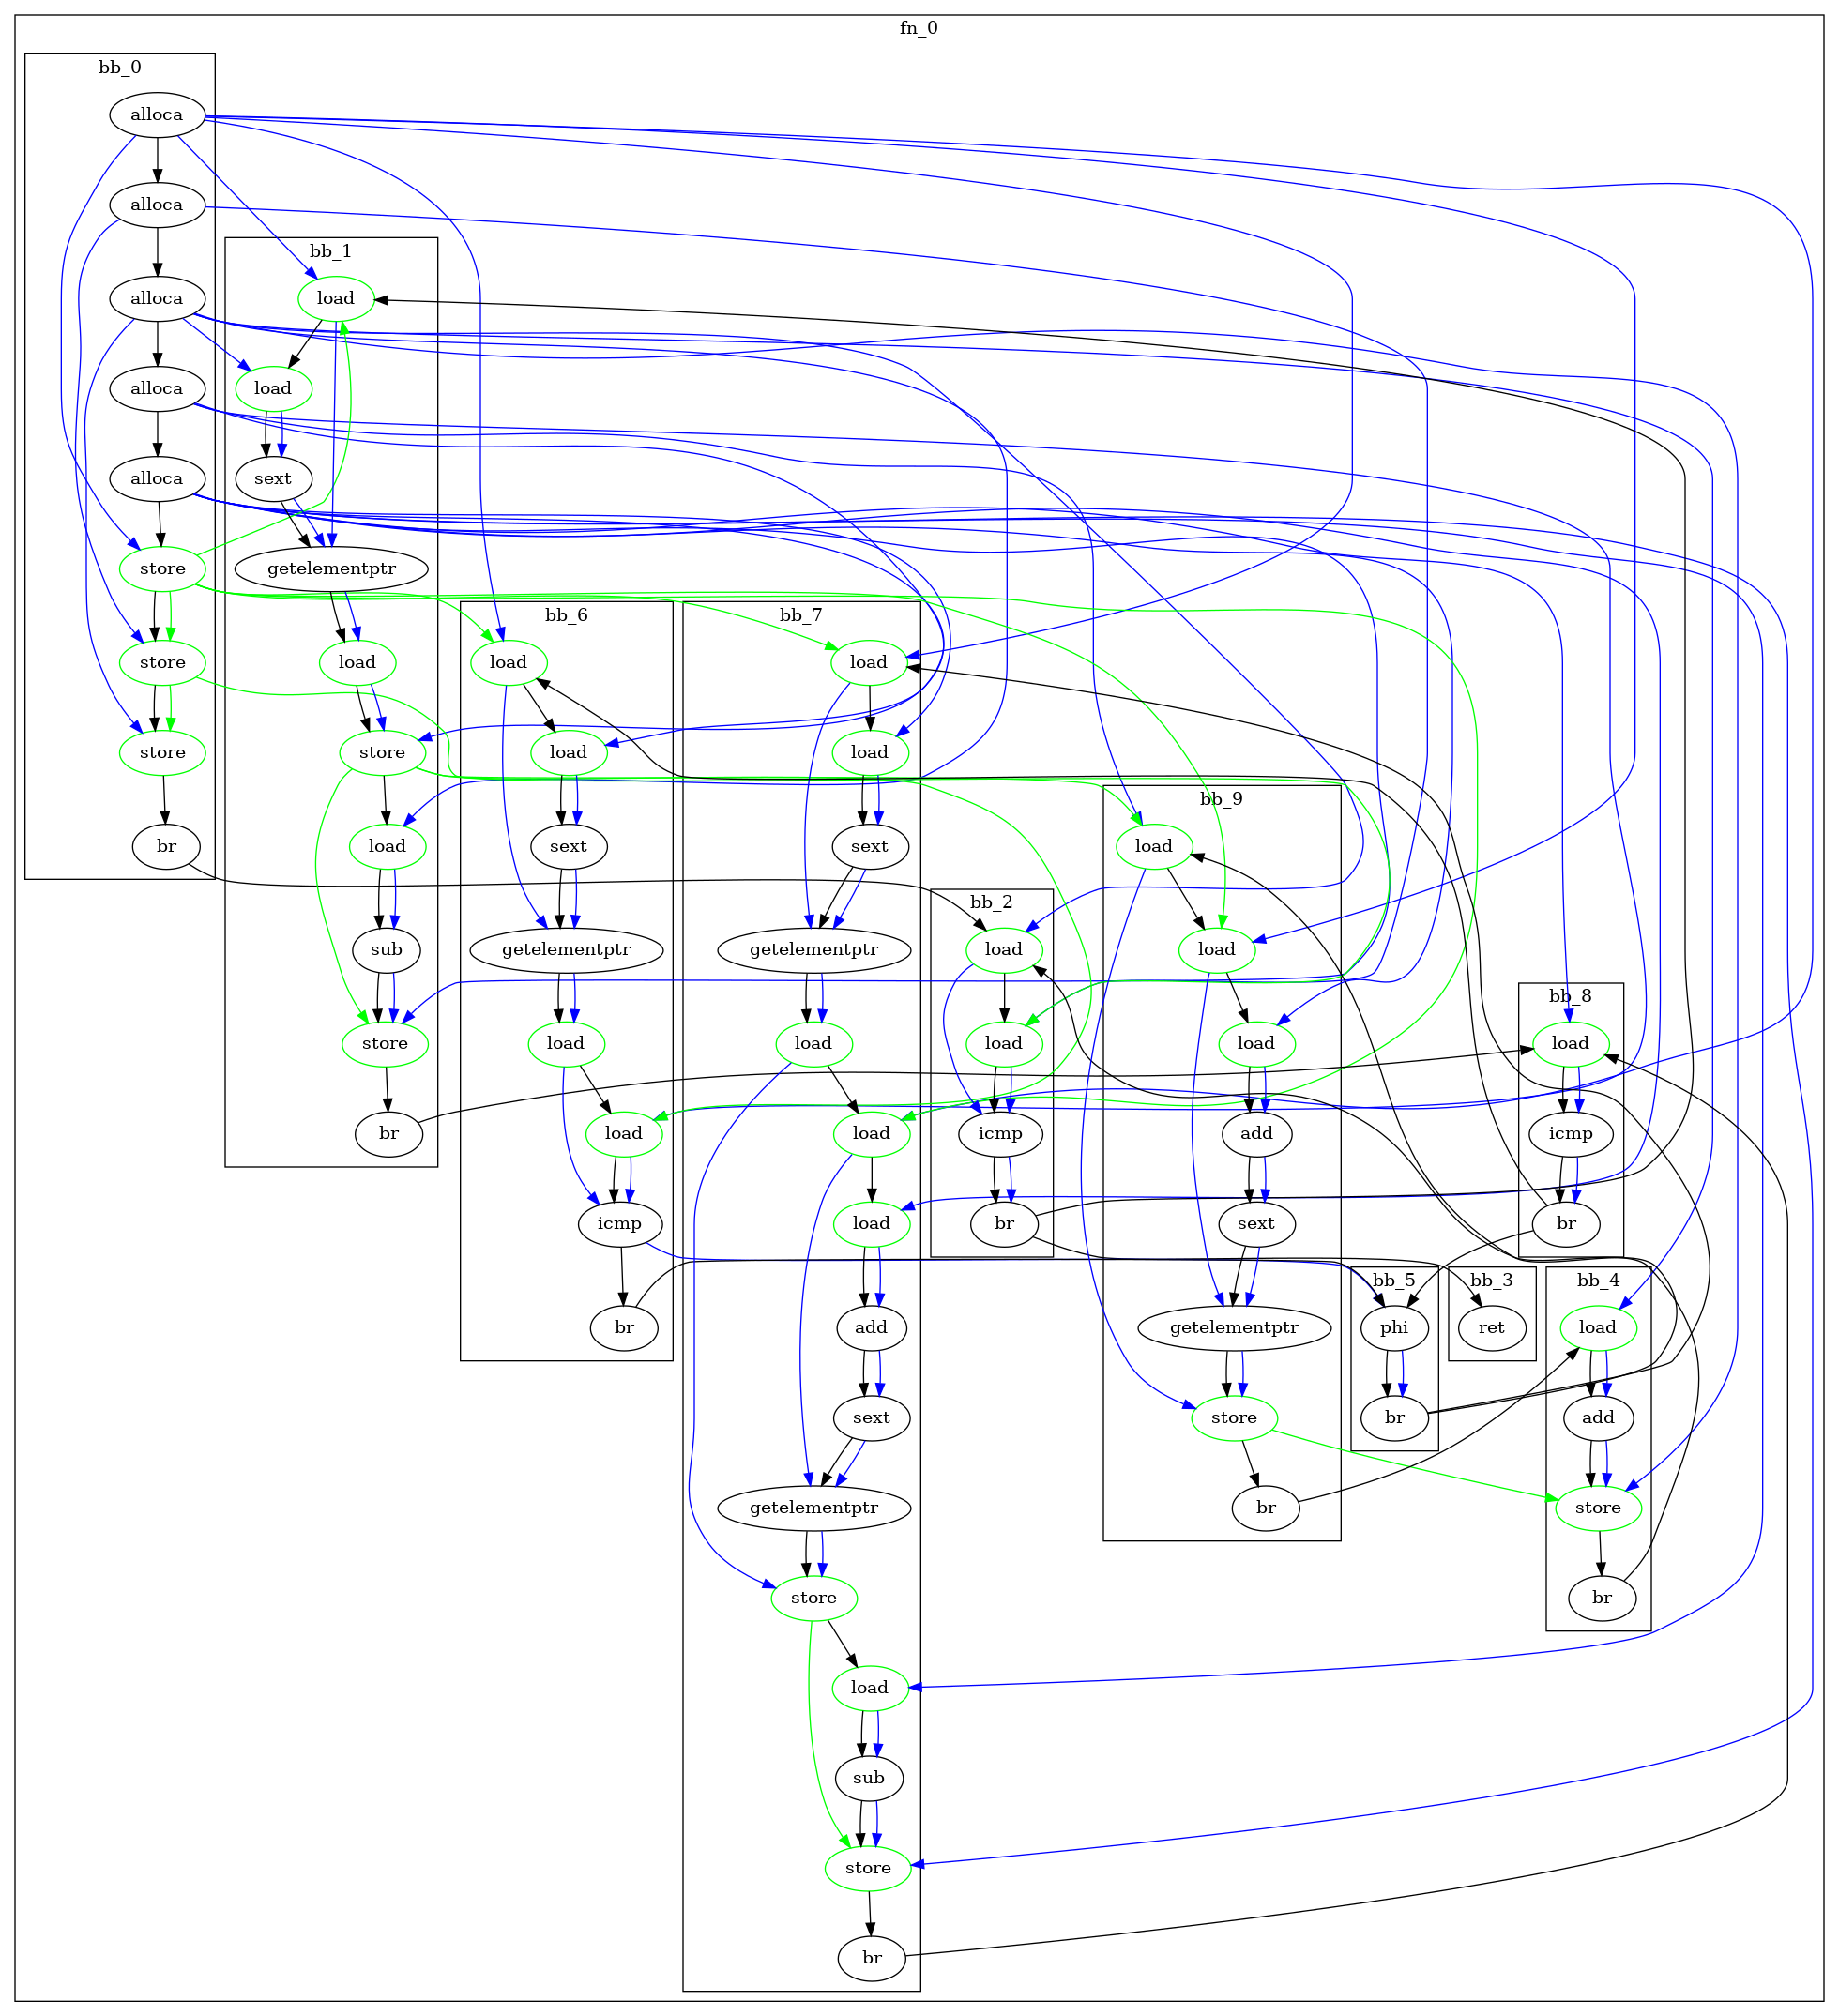

In [6]:
import lib.representations.llvm.codegraph_models as llvm_codegraph_models
import lib.representations.llvm.preprocess as llvm_preprocess
    
def gen_and_view_llvm(src):
    # Extract LLVM graphs from C code
    miner_output = llvm_preprocess.process_source_buffer(src, ['-O0'])[0]
    # Parse LLVM graph
    graph = llvm_codegraph_models.codegraphs_create_from_miner_output(json.loads(miner_output))[0]

    dot_graph = llvm_codegraph_models.make_dot_graph(graph)
    return dot_graph.dot

preamble.view_dots([gen_and_view_llvm(example1), gen_and_view_llvm(example2)])
preamble.view_dots([gen_and_view_llvm(example3), gen_and_view_llvm(example4)])

## Evaluation tasks<a name="eval"></a>

The raw data used for constructing the datasets for the tasks is taken from [1]. It consists of selected OpenCL kernels from the benchmark suites NPB, Rodinia, NVIDIA SDK, AMD SDK, Parboil, PolyBench, and SHOC.
We enrich the raw datasets of [1] with the introduced AST- and CDFG representations. For this, we exercise our preprocessing pipeline, resulting in a graph-based representation of each of the OpenCL kernels.

Training the model is a major effort in terms of computation. The models of the published results were trained on an HPC cluster, using the SLURM management system.

We include the pre-trained models in the folder "results/.../.../models". 
The code in the following cells will load the pre-trained model and use it for making predictions on the test set.
Re-training the models can be achieved by deleting the "models" directory in the methods directories.

### CPU/CPU Mapping<a name="devmap"></a>

#### Building the dataset<a name="devmap-data"></a>

The raw data used for constructing the datasets for the tasks is taken from [1]. It consists of selected OpenCL kernels from the benchmark suites NPB, Rodinia, NVIDIA SDK, AMD SDK, Parboil, PolyBench, and SHOC.
We enrich the raw datasets of [1] with the introduced AST- and CDFG representations. For this, we exercise our preprocessing pipeline, resulting in a graph-based representation of each of the OpenCL kernels.

Training the model is a major effort in terms of computation. The models of the published results were trained on an HPC cluster, using the SLURM management system.

We include the pre-trained models in the folder "results/.../.../models". 
The code in the following cells will load the pre-trained model and use it for making predictions on the test set.
Re-training the models can be achieved by deleting the "models" directory in the methods directories.

In [7]:
print('Preprocessing AMD')
DevMapExperiment.preprocess(
    code_dir='dependencies/benchmarks_srcs',
    preprocessing_artifact_dir='/tmp/amd',
    cgo17_benchmarks_csv='dependencies/paper-end2end-dl/data/case-study-a/cgo17-amd.csv',
    cgo17_benchmarks_csv_out='data/devmap/amd.csv')

print('Preprocessing Nvidia')
DevMapExperiment.preprocess(
    code_dir='dependencies/benchmarks_srcs',
    preprocessing_artifact_dir='/tmp/nvidia',
    cgo17_benchmarks_csv='dependencies/paper-end2end-dl/data/case-study-a/cgo17-nvidia.csv',
    cgo17_benchmarks_csv_out='data/devmap/nvidia.csv')

Preprocessing AMD
LLVM graphs -> Dataset: 100%|██████████| 346/346 [00:19<00:00, 17.83it/s]
{
  "Clang": {
    "num_nodes_max": 11045,
    "num_nodes_mean": 767,
    "num_node_types": 68
  },
  "LLVM": {
    "num_nodes_max": 4537,
    "num_nodes_mean": 597,
    "num_node_types": 140
  }
}
Preprocessing Nvidia
LLVM graphs -> Dataset: 100%|██████████| 346/346 [00:21<00:00, 15.99it/s]
{
  "Clang": {
    "num_nodes_max": 11045,
    "num_nodes_mean": 767,
    "num_node_types": 68
  },
  "LLVM": {
    "num_nodes_max": 4537,
    "num_nodes_mean": 597,
    "num_node_types": 140
  }
}


#### Training and Predicting<a name="devmap-train"></a>

##### Stratified 10-fold cross validation<a name="devmap-train"></a>


In [8]:
# AST
for iteration in range(10):
    DevMapExperiment.experiment(
        dataset_amd='data/devmap/amd.csv',
        dataset_nvidia='data/devmap/nvidia.csv',
        datasets=['amd', 'nvidia'],
        fold_mode='random',
        seed=iteration+1,
        report_write_dir='results/devmap/devmap_gnn_ast_random',
        gnn_ast=True)


Training/Predicting GNN-AST with seed 1 ...
nvidia: 100%|██████████| 10/10 [00:32<00:00,  3.23s/it]

Training/Predicting GNN-AST with seed 2 ...
nvidia: 100%|██████████| 10/10 [00:29<00:00,  3.00s/it]

Training/Predicting GNN-AST with seed 3 ...
nvidia: 100%|██████████| 10/10 [00:30<00:00,  3.02s/it]

Training/Predicting GNN-AST with seed 4 ...
nvidia: 100%|██████████| 10/10 [00:30<00:00,  3.05s/it]

Training/Predicting GNN-AST with seed 5 ...
nvidia: 100%|██████████| 10/10 [00:29<00:00,  2.98s/it]

Training/Predicting GNN-AST with seed 6 ...
nvidia: 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]

Training/Predicting GNN-AST with seed 7 ...
nvidia: 100%|██████████| 10/10 [00:30<00:00,  3.04s/it]

Training/Predicting GNN-AST with seed 8 ...
nvidia: 100%|██████████| 10/10 [00:29<00:00,  2.97s/it]

Training/Predicting GNN-AST with seed 9 ...
nvidia: 100%|██████████| 10/10 [00:29<00:00,  2.97s/it]

Training/Predicting GNN-AST with seed 10 ...
nvidia: 100%|██████████| 10/10 [00:29<00:00, 

In [9]:
# CDFG
for iteration in range(10):
    DevMapExperiment.experiment(
        dataset_amd='data/devmap/amd.csv',
        dataset_nvidia='data/devmap/nvidia.csv',
        datasets=['amd', 'nvidia'],
        fold_mode='random',
        seed=iteration+1,
        report_write_dir='results/devmap/devmap_gnn_llvm_random',
        gnn_llvm=True)


Training/Predicting GNN-LLVM with seed 1 ...
nvidia: 100%|██████████| 10/10 [00:32<00:00,  3.29s/it]

Training/Predicting GNN-LLVM with seed 2 ...
nvidia: 100%|██████████| 10/10 [00:30<00:00,  3.07s/it]

Training/Predicting GNN-LLVM with seed 3 ...
nvidia: 100%|██████████| 10/10 [00:32<00:00,  3.20s/it]

Training/Predicting GNN-LLVM with seed 4 ...
nvidia: 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]

Training/Predicting GNN-LLVM with seed 5 ...
nvidia: 100%|██████████| 10/10 [00:31<00:00,  3.18s/it]

Training/Predicting GNN-LLVM with seed 6 ...
nvidia: 100%|██████████| 10/10 [00:31<00:00,  3.15s/it]

Training/Predicting GNN-LLVM with seed 7 ...
nvidia: 100%|██████████| 10/10 [00:31<00:00,  3.11s/it]

Training/Predicting GNN-LLVM with seed 8 ...
nvidia: 100%|██████████| 10/10 [00:30<00:00,  3.09s/it]

Training/Predicting GNN-LLVM with seed 9 ...
nvidia: 100%|██████████| 10/10 [00:30<00:00,  3.08s/it]

Training/Predicting GNN-LLVM with seed 10 ...
nvidia: 100%|██████████| 10/10 [00:

In [10]:
# DeepTune baseline
for iteration in range(10):
    DevMapExperiment.experiment(
        dataset_amd='data/devmap/amd.csv',
        dataset_nvidia='data/devmap/nvidia.csv',
        datasets=['amd', 'nvidia'],
        fold_mode='random',
        seed=iteration+1,
        report_write_dir='results/devmap/devmap_deeptune_random',
        deeptune=True)


Training/Predicting DeepTune with seed 1 ...
amd:   0%|          | 0/10 [00:00<?, ?it/s]

Using TensorFlow backend.


nvidia: 100%|██████████| 10/10 [01:11<00:00,  7.17s/it]

Training/Predicting DeepTune with seed 2 ...
nvidia: 100%|██████████| 10/10 [01:11<00:00,  7.15s/it]

Training/Predicting DeepTune with seed 3 ...
nvidia: 100%|██████████| 10/10 [01:11<00:00,  7.19s/it]

Training/Predicting DeepTune with seed 4 ...
nvidia: 100%|██████████| 10/10 [01:11<00:00,  7.16s/it]

Training/Predicting DeepTune with seed 5 ...
nvidia: 100%|██████████| 10/10 [01:11<00:00,  7.16s/it]

Training/Predicting DeepTune with seed 6 ...
nvidia: 100%|██████████| 10/10 [01:11<00:00,  7.19s/it]

Training/Predicting DeepTune with seed 7 ...
nvidia: 100%|██████████| 10/10 [01:11<00:00,  7.19s/it]

Training/Predicting DeepTune with seed 8 ...
nvidia: 100%|██████████| 10/10 [01:11<00:00,  7.20s/it]

Training/Predicting DeepTune with seed 9 ...
nvidia: 100%|██████████| 10/10 [01:11<00:00,  7.20s/it]

Training/Predicting DeepTune with seed 10 ...
nvidia: 100%|██████████| 10/10 [01:12<00:00,  7.21s/it]


In [11]:
# Inst2vec baseline
source envs/ncc/bin/activate
cd dependencies/ncc/
 
for iteration in {1..10}
do
  python train_task_devmap.py --out /home/artifact/results/devmap/devmap_inst2vec_random --fold_mode random --seed $iteration &> /dev/null
done

deactivate
cd ../..

(ncc) (ncc) (ncc) (ncc) (ncc) 


In [12]:
# Grewe et al baseline
for iteration in range(10):
    DevMapExperiment.experiment(
        dataset_amd='data/devmap/amd.csv',
        dataset_nvidia='data/devmap/nvidia.csv',
        datasets=['amd', 'nvidia'],
        fold_mode='random',
        seed=iteration+1,
        report_write_dir='results/devmap/devmap_grewe_random',
        grewe=True)


Training/Predicting Grewe et al. with seed 1 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Grewe et al. with seed 2 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Grewe et al. with seed 3 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Grewe et al. with seed 4 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Grewe et al. with seed 5 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Grewe et al. with seed 6 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Grewe et al. with seed 7 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]

Training/Predicting Grewe et al. with seed 8 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Grewe et al. with seed 9 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Grewe et al. with seed 10

In [13]:
# Static mapping baseline
DevMapExperiment.experiment(
    dataset_amd='data/devmap/amd.csv',
    dataset_nvidia='data/devmap/nvidia.csv',
    datasets=['amd', 'nvidia'],
    fold_mode='random',
    seed=1,
    report_write_dir='results/devmap/devmap_static_random',
    static=True)


Training/Predicting Static mapping with seed 1 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


In [14]:
# Random mapping baseline
for iteration in range(10):
    DevMapExperiment.experiment(
        dataset_amd='data/devmap/amd.csv',
        dataset_nvidia='data/devmap/nvidia.csv',
        datasets=['amd', 'nvidia'],
        fold_mode='random',
        seed=iteration+1,
        report_write_dir='results/devmap/devmap_random_random',
        random=True)


Training/Predicting Random mapping with seed 1 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Random mapping with seed 2 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Random mapping with seed 3 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Random mapping with seed 4 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]

Training/Predicting Random mapping with seed 5 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

Training/Predicting Random mapping with seed 6 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Random mapping with seed 7 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Random mapping with seed 8 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

Training/Predicting Random mapping with seed 9 ...
nvidia: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Training/Predicting Random 

In [15]:
./consolidate_csvs_devmap.sh 2> /dev/null

In [16]:
devmap_random <- read_csv("devmap_random.csv")

Parsed with column specification:
cols(
  filename = col_character(),
  Model = col_character(),
  Platform = col_character(),
  Benchmark = col_character(),
  `Benchmark Suite` = col_character(),
  `Oracle Mapping` = col_double(),
  `Predicted Mapping` = col_double(),
  `Correct?` = col_logical(),
  Speedup = col_double(),
  Fold = col_double(),
  num_trainable_parameters = col_double()
)



In [17]:
random_with_accuracy <- group_by(devmap_random,Model,Platform) %>%
  summarize(Accuracy=sum(`Correct?`)/length(`Correct?`),Speedup=gm_mean(Speedup)) %>%
  ungroup()
random_with_accuracy$`Model` <- factor(random_with_accuracy$`Model`,levels = c("Random mapping","Static mapping","Grewe et al.", "DeepTune", "inst2vec", "GNN-LLVM", "GNN-AST"))

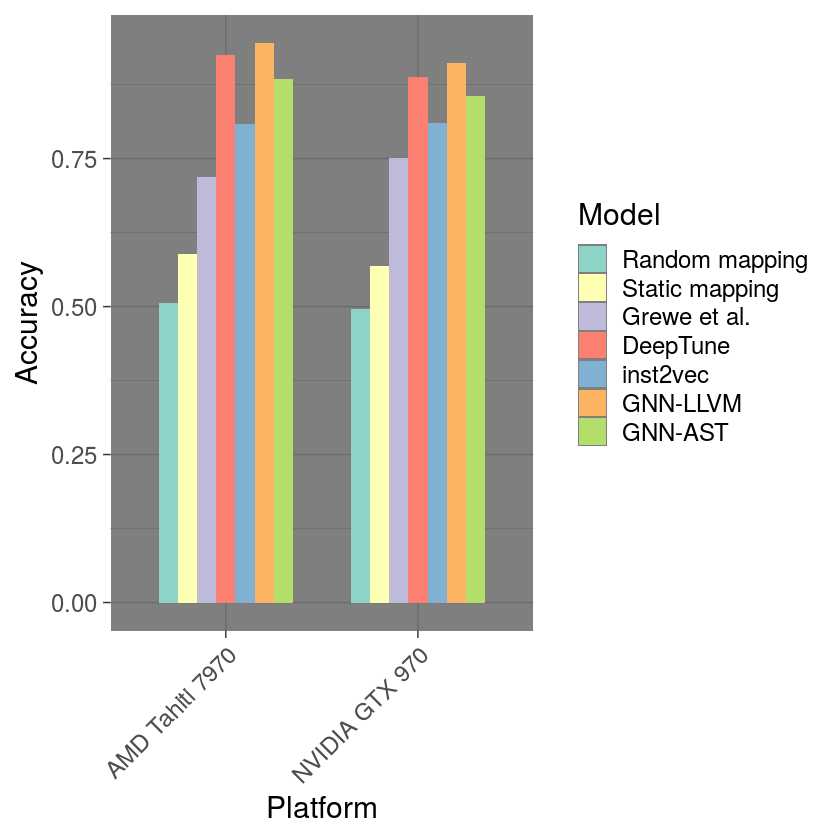

In [18]:
ggplot(data = random_with_accuracy) +
      geom_col(width=0.7,position='dodge',mapping = aes(x=`Platform`,y=Accuracy,fill=Model)) +
      scale_fill_manual(values = brewer.pal(n = 7, name = "Set3")) +
      theme_dark(base_size = 18) +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
options(repr.plot.width=30, repr.plot.height=9)

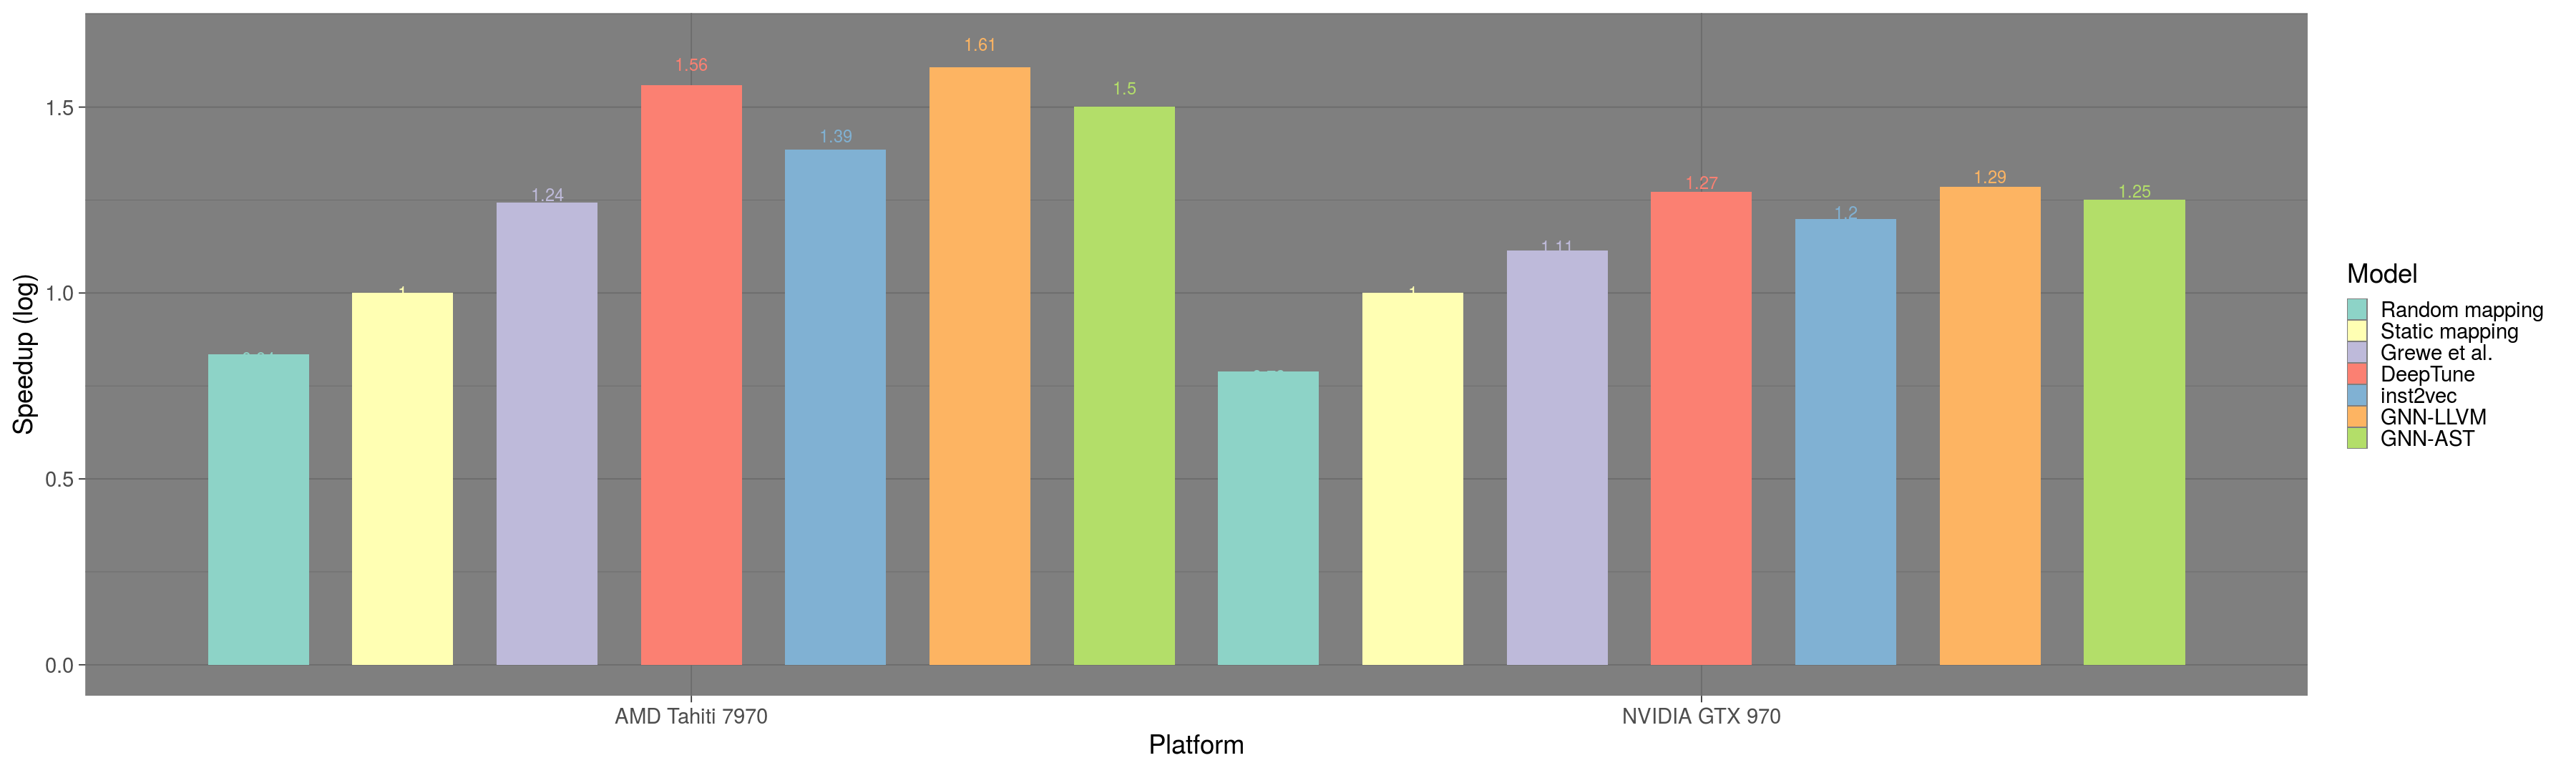

In [19]:
ggplot(data = random_with_accuracy) +
      geom_col(width=0.7,position=position_dodge(width=TRUE),mapping = aes(x=`Platform`,y=Speedup,fill=Model)) +
      #scale_y_log10() + #add this for better visualization (camera ready)
      labs( y = 'Speedup (log)') +
      scale_fill_manual(values = brewer.pal(n = 7, name = "Set3")) +
      geom_text(size = 5, position = position_dodge(width=TRUE),mapping = aes(x=`Platform`,y=10^(log10(Speedup)*1.08),colour=Model,label=round(Speedup,digits=2))) +
      scale_colour_manual(values = brewer.pal(n = 7, name = "Set3")) +
      theme_dark(base_size = 22) 
options(repr.plot.width=30, repr.plot.height=9)

##### Grouped 7-fold cross validation<a name="devmap-train"></a>


In [20]:
# AST
for iteration in range(10):
    DevMapExperiment.experiment(
        dataset_amd='data/devmap/amd.csv',
        dataset_nvidia='data/devmap/nvidia.csv',
        datasets=['amd', 'nvidia'],
        fold_mode='grouped',
        seed=iteration+1,
        report_write_dir='results/devmap/devmap_gnn_ast_grouped',
        gnn_ast=True)


Training/Predicting GNN-AST with seed 1 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.16s/it]

Training/Predicting GNN-AST with seed 2 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.16s/it]

Training/Predicting GNN-AST with seed 3 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.17s/it]

Training/Predicting GNN-AST with seed 4 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.16s/it]

Training/Predicting GNN-AST with seed 5 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.15s/it]

Training/Predicting GNN-AST with seed 6 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.16s/it]

Training/Predicting GNN-AST with seed 7 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.16s/it]

Training/Predicting GNN-AST with seed 8 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.16s/it]

Training/Predicting GNN-AST with seed 9 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.15s/it]

Training/Predicting GNN-AST with seed 10 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.16s/it]


In [21]:
# CDFG
for iteration in range(10):
    DevMapExperiment.experiment(
        dataset_amd='data/devmap/amd.csv',
        dataset_nvidia='data/devmap/nvidia.csv',
        datasets=['amd', 'nvidia'],
        fold_mode='grouped',
        seed=iteration+1,
        report_write_dir='results/devmap/devmap_gnn_llvm_grouped',
        gnn_llvm=True)


Training/Predicting GNN-LLVM with seed 1 ...
nvidia: 100%|██████████| 7/7 [00:23<00:00,  3.30s/it]

Training/Predicting GNN-LLVM with seed 2 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.28s/it]

Training/Predicting GNN-LLVM with seed 3 ...
nvidia: 100%|██████████| 7/7 [00:23<00:00,  3.29s/it]

Training/Predicting GNN-LLVM with seed 4 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.27s/it]

Training/Predicting GNN-LLVM with seed 5 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.27s/it]

Training/Predicting GNN-LLVM with seed 6 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.28s/it]

Training/Predicting GNN-LLVM with seed 7 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.28s/it]

Training/Predicting GNN-LLVM with seed 8 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.27s/it]

Training/Predicting GNN-LLVM with seed 9 ...
nvidia: 100%|██████████| 7/7 [00:22<00:00,  3.27s/it]

Training/Predicting GNN-LLVM with seed 10 ...
nvidia: 100%|██████████| 7/7 [00:23<00:00,  3.29s/it]

In [22]:
# DeepTune baseline
for iteration in range(10):
    DevMapExperiment.experiment(
        dataset_amd='data/devmap/amd.csv',
        dataset_nvidia='data/devmap/nvidia.csv',
        datasets=['amd', 'nvidia'],
        fold_mode='grouped',
        seed=iteration+1,
        report_write_dir='results/devmap/devmap_deeptune_grouped',
        deeptune=True)


Training/Predicting DeepTune with seed 1 ...
nvidia: 100%|██████████| 7/7 [00:51<00:00,  7.41s/it]

Training/Predicting DeepTune with seed 2 ...
nvidia: 100%|██████████| 7/7 [00:51<00:00,  7.43s/it]

Training/Predicting DeepTune with seed 3 ...
nvidia: 100%|██████████| 7/7 [00:52<00:00,  7.43s/it]

Training/Predicting DeepTune with seed 4 ...
nvidia: 100%|██████████| 7/7 [00:51<00:00,  7.42s/it]

Training/Predicting DeepTune with seed 5 ...
nvidia: 100%|██████████| 7/7 [00:51<00:00,  7.41s/it]

Training/Predicting DeepTune with seed 6 ...
nvidia: 100%|██████████| 7/7 [00:52<00:00,  7.44s/it]

Training/Predicting DeepTune with seed 7 ...
nvidia: 100%|██████████| 7/7 [00:52<00:00,  7.44s/it]

Training/Predicting DeepTune with seed 8 ...
nvidia: 100%|██████████| 7/7 [00:51<00:00,  7.41s/it]

Training/Predicting DeepTune with seed 9 ...
nvidia: 100%|██████████| 7/7 [00:51<00:00,  7.42s/it]

Training/Predicting DeepTune with seed 10 ...
nvidia: 100%|██████████| 7/7 [00:52<00:00,  7.44s/it]

In [23]:
# Inst2vec baseline
source envs/ncc/bin/activate
cd dependencies/ncc/
 
for iteration in {1..10}
do
  python train_task_devmap.py --out /home/artifact/results/devmap/devmap_inst2vec_grouped --fold_mode grouped --seed $iteration &> /dev/null
done

deactivate
cd ../..

(ncc) (ncc) (ncc) (ncc) (ncc) 


In [24]:
# Grewe et al baseline
for iteration in range(10):
    DevMapExperiment.experiment(
        dataset_amd='data/devmap/amd.csv',
        dataset_nvidia='data/devmap/nvidia.csv',
        datasets=['amd', 'nvidia'],
        fold_mode='grouped',
        seed=iteration+1,
        report_write_dir='results/devmap/devmap_grewe_grouped',
        grewe=True)


Training/Predicting Grewe et al. with seed 1 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]

Training/Predicting Grewe et al. with seed 2 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

Training/Predicting Grewe et al. with seed 3 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]

Training/Predicting Grewe et al. with seed 4 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]

Training/Predicting Grewe et al. with seed 5 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

Training/Predicting Grewe et al. with seed 6 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

Training/Predicting Grewe et al. with seed 7 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

Training/Predicting Grewe et al. with seed 8 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

Training/Predicting Grewe et al. with seed 9 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]

Training/Predicting Grewe et al. with seed 10 ...
nvidia: 100%|

In [25]:
# Static mapping baseline
DevMapExperiment.experiment(
    dataset_amd='data/devmap/amd.csv',
    dataset_nvidia='data/devmap/nvidia.csv',
    datasets=['amd', 'nvidia'],
    fold_mode='grouped',
    seed=1,
    report_write_dir='results/devmap/devmap_static_grouped',
    static=True)


Training/Predicting Static mapping with seed 1 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


In [26]:
# Random mapping baseline
for iteration in range(10):
    DevMapExperiment.experiment(
        dataset_amd='data/devmap/amd.csv',
        dataset_nvidia='data/devmap/nvidia.csv',
        datasets=['amd', 'nvidia'],
        fold_mode='grouped',
        seed=iteration+1,
        report_write_dir='results/devmap/devmap_random_grouped',
        random=True)


Training/Predicting Random mapping with seed 1 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

Training/Predicting Random mapping with seed 2 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]

Training/Predicting Random mapping with seed 3 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]

Training/Predicting Random mapping with seed 4 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]

Training/Predicting Random mapping with seed 5 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]

Training/Predicting Random mapping with seed 6 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]

Training/Predicting Random mapping with seed 7 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

Training/Predicting Random mapping with seed 8 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

Training/Predicting Random mapping with seed 9 ...
nvidia: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]

Training/Predicting Random mapping with seed 

In [27]:
./consolidate_csvs_devmap.sh 2> /dev/null

In [28]:
devmap_grouped <- read_csv("devmap_grouped.csv")

Parsed with column specification:
cols(
  filename = col_character(),
  Model = col_character(),
  Platform = col_character(),
  Benchmark = col_character(),
  `Benchmark Suite` = col_character(),
  `Oracle Mapping` = col_double(),
  `Predicted Mapping` = col_double(),
  `Correct?` = col_logical(),
  Speedup = col_double(),
  Fold = col_double(),
  num_trainable_parameters = col_double()
)



In [29]:
grouped_with_accuracy <- group_by(devmap_grouped,Model,Platform,`Benchmark Suite`) %>%
  summarize(Accuracy=sum(`Correct?`)/length(`Correct?`),Speedup=gm_mean(Speedup)) %>%
  ungroup()

In [30]:
grouped_gmeans <- group_by(grouped_with_accuracy,Model,Platform) %>%
    summarize(mean_accuracy = mean(Accuracy), Gmean_speedup = gm_mean(Speedup)) %>%
    ungroup() %>%
    transmute(Model=Model,Platform=Platform,`Benchmark Suite`="Mean",Accuracy=mean_accuracy,Speedup=Gmean_speedup)
grouped_with_gmeans <- rbind(grouped_with_accuracy,grouped_gmeans)

In [31]:
#sort
grouped_with_gmeans$`Benchmark Suite` <- factor(grouped_with_gmeans$`Benchmark Suite`,levels = c("AMD SDK","NPB","NVIDIA SDK","Parboil","Polybench","Rodinia","SHOC","Gmean"))
grouped_with_gmeans$`Model` <- factor(grouped_with_gmeans$`Model`,levels = c("Random mapping","Static mapping","Grewe et al.", "DeepTune", "inst2vec", "GNN-LLVM", "GNN-AST"))

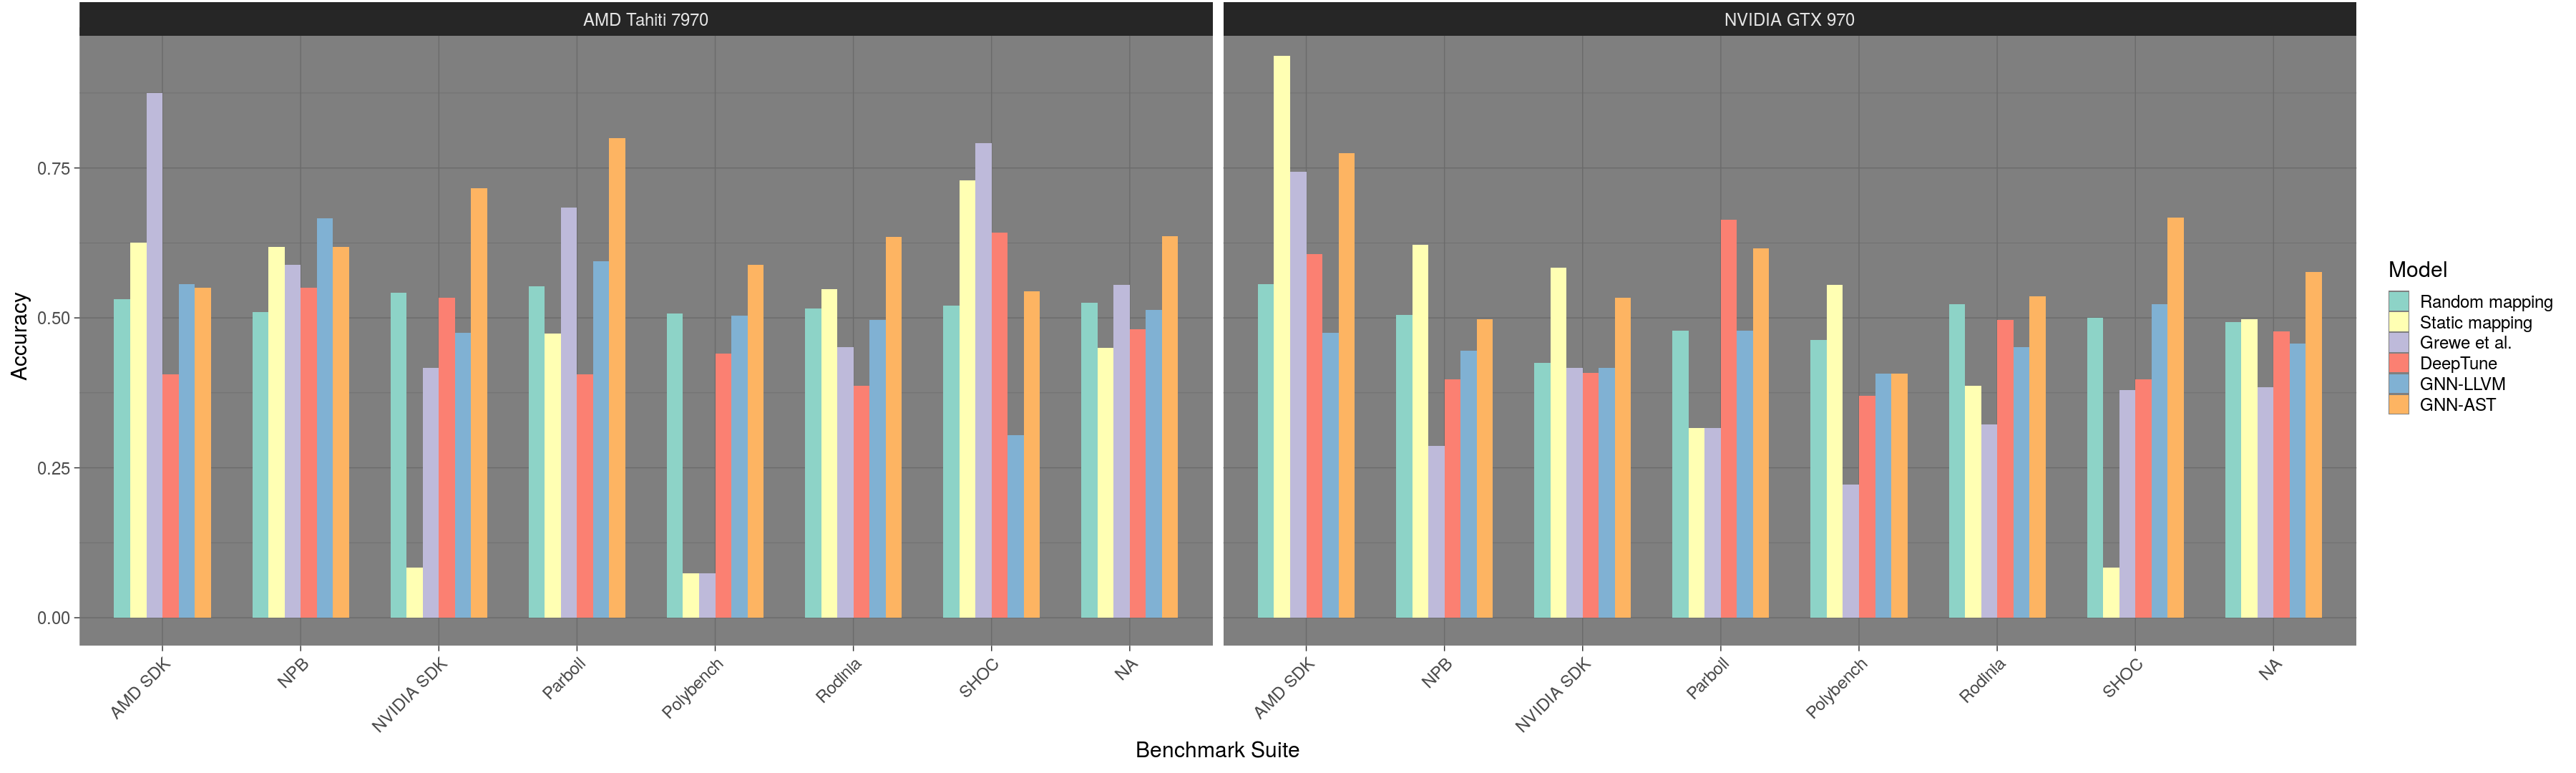

In [32]:
ggplot(data = grouped_with_gmeans) +
      geom_col(width=0.7,position='dodge',mapping = aes(x=`Benchmark Suite`,y=Accuracy,fill=Model)) +
      facet_wrap(~Platform) +
      theme_dark(base_size = 18) +
      scale_fill_manual(values = brewer.pal(n = 7, name = "Set3")) +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
options(repr.plot.width=40, repr.plot.height=9)

### Thread coarsening task<a name="tc"></a>

#### Building the dataset<a name="tc-data"></a>

In [33]:
ThreadCoarsenExperiment.preprocess(
    code_dir='dependencies/benchmarks_srcs',
    preprocessing_artifact_dir='/tmp/tc',
    cgo17_runtimes_csv='dependencies/paper-end2end-dl/data/case-study-b/pact-2014-runtimes.csv',
    cgo17_runtimes_csv_out='data/tc/pact-2014-runtimes.csv')

C -> LLVM graphs: 100%|██████████| 17/17 [00:34<00:00,  2.04s/it]
{
  "Clang": {
    "num_node_types": 45
  },
  "LLVM": {
    "num_node_types": 53
  }
}


#### Training and Predicting<a name="devmap-train"></a>


In [34]:
# AST
for iteration in range(10):
    ThreadCoarsenExperiment.experiment(
        runtimes_csv='data/tc/pact-2014-runtimes.csv',
        oracles_csv='dependencies/paper-end2end-dl/data/case-study-b/pact-2014-oracles.csv',
        devmap_amd_csv='dependencies/paper-end2end-dl/data/case-study-a/cgo17-amd.csv',
        seed=iteration+1,
        report_write_dir='results/tc/tc_gnn_ast',
        gnn_ast=True)


Training/Predicting GNN-AST with seed 1 ...
Kepler: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]

Training/Predicting GNN-AST with seed 2 ...
Kepler: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]

Training/Predicting GNN-AST with seed 3 ...
Kepler: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]

Training/Predicting GNN-AST with seed 4 ...
Kepler: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]

Training/Predicting GNN-AST with seed 5 ...
Kepler: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]

Training/Predicting GNN-AST with seed 6 ...
Kepler: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]

Training/Predicting GNN-AST with seed 7 ...
Kepler: 100%|██████████| 17/17 [00:16<00:00,  1.00it/s]

Training/Predicting GNN-AST with seed 8 ...
Kepler: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]

Training/Predicting GNN-AST with seed 9 ...
Kepler: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]

Training/Predicting GNN-AST with seed 10 ...
Kepler: 100%|██████████| 17/17 [00:16<00:00, 

In [35]:
# CDFG
for iteration in range(10):
    ThreadCoarsenExperiment.experiment(
        runtimes_csv='data/tc/pact-2014-runtimes.csv',
        oracles_csv='dependencies/paper-end2end-dl/data/case-study-b/pact-2014-oracles.csv',
        devmap_amd_csv='dependencies/paper-end2end-dl/data/case-study-a/cgo17-amd.csv',
        seed=iteration+1,
        report_write_dir='results/tc/tc_gnn_llvm',
        gnn_llvm=True)


Training/Predicting GNN-LLVM with seed 1 ...
Kepler: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]

Training/Predicting GNN-LLVM with seed 2 ...
Kepler: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]

Training/Predicting GNN-LLVM with seed 3 ...
Kepler: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]

Training/Predicting GNN-LLVM with seed 4 ...
Kepler: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]

Training/Predicting GNN-LLVM with seed 5 ...
Kepler: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]

Training/Predicting GNN-LLVM with seed 6 ...
Kepler: 100%|██████████| 17/17 [00:18<00:00,  1.12s/it]

Training/Predicting GNN-LLVM with seed 7 ...
Kepler: 100%|██████████| 17/17 [00:19<00:00,  1.14s/it]

Training/Predicting GNN-LLVM with seed 8 ...
Kepler: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]

Training/Predicting GNN-LLVM with seed 9 ...
Kepler: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]

Training/Predicting GNN-LLVM with seed 10 ...
Kepler: 100%|██████████| 17/17 [00:

In [36]:
# DeepTune baseline
for iteration in range(10):
    ThreadCoarsenExperiment.experiment(
        runtimes_csv='data/tc/pact-2014-runtimes.csv',
        oracles_csv='dependencies/paper-end2end-dl/data/case-study-b/pact-2014-oracles.csv',
        devmap_amd_csv='dependencies/paper-end2end-dl/data/case-study-a/cgo17-amd.csv',
        seed=iteration+1,
        report_write_dir='results/tc/tc_deeptune',
        deeptune=True)


Training/Predicting DeepTune with seed 1 ...
Kepler: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

Training/Predicting DeepTune with seed 2 ...
Kepler: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

Training/Predicting DeepTune with seed 3 ...
Kepler: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

Training/Predicting DeepTune with seed 4 ...
Kepler: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

Training/Predicting DeepTune with seed 5 ...
Kepler: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

Training/Predicting DeepTune with seed 6 ...
Kepler: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

Training/Predicting DeepTune with seed 7 ...
Kepler: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

Training/Predicting DeepTune with seed 8 ...
Kepler: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

Training/Predicting DeepTune with seed 9 ...
Kepler: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

Training/Predicting DeepTune with seed 10 ...
Kepler: 100%|██████████| 17/17 [00:

In [37]:
# Inst2vec baseline
source envs/ncc/bin/activate
cd dependencies/ncc/
 
for iteration in {1..10}
do
  python train_task_threadcoarsening.py --out /home/artifact/results/tc/tc_inst2vec --seed $iteration &> /dev/null
done

deactivate
cd ../..

(ncc) (ncc) (ncc) (ncc) (ncc) 


In [38]:
# Magni baseline
for iteration in range(10):
    ThreadCoarsenExperiment.experiment(
        runtimes_csv='data/tc/pact-2014-runtimes.csv',
        oracles_csv='dependencies/paper-end2end-dl/data/case-study-b/pact-2014-oracles.csv',
        devmap_amd_csv='dependencies/paper-end2end-dl/data/case-study-a/cgo17-amd.csv',
        seed=iteration+1,
        report_write_dir='results/tc/tc_magni',
        magni=True)


Training/Predicting Magni et al. with seed 1 ...
Kepler: 100%|██████████| 17/17 [00:00<00:00, 94.29it/s]

Training/Predicting Magni et al. with seed 2 ...
Kepler: 100%|██████████| 17/17 [00:00<00:00, 97.84it/s]

Training/Predicting Magni et al. with seed 3 ...
Kepler: 100%|██████████| 17/17 [00:00<00:00, 81.51it/s]

Training/Predicting Magni et al. with seed 4 ...
Kepler: 100%|██████████| 17/17 [00:00<00:00, 73.07it/s] 

Training/Predicting Magni et al. with seed 5 ...
Kepler: 100%|██████████| 17/17 [00:00<00:00, 96.06it/s]

Training/Predicting Magni et al. with seed 6 ...
Kepler: 100%|██████████| 17/17 [00:00<00:00, 81.91it/s]

Training/Predicting Magni et al. with seed 7 ...
Kepler: 100%|██████████| 17/17 [00:00<00:00, 72.46it/s] 

Training/Predicting Magni et al. with seed 8 ...
Kepler: 100%|██████████| 17/17 [00:00<00:00, 161.81it/s]

Training/Predicting Magni et al. with seed 9 ...
Kepler: 100%|██████████| 17/17 [00:00<00:00, 93.45it/s]

Training/Predicting Magni et al. with seed

In [39]:
./consolidate_csvs_tc.sh 2> /dev/null

In [40]:
devmap_tc <- read_csv("tc.csv")

Parsed with column specification:
cols(
  filename = col_character(),
  Model = col_character(),
  Platform = col_character(),
  Kernel = col_character(),
  `Oracle-CF` = col_double(),
  `Predicted-CF` = col_double(),
  Speedup = col_double(),
  Oracle = col_double(),
  num_trainable_parameters = col_double(),
  train_time = col_double(),
  inference_time = col_double()
)



In [41]:
tc_with_diffs <- transform(devmap_tc, tc_factor_power_diff = log2(`Oracle-CF`) - log2(`Predicted-CF`))
tc_with_summaries <- group_by(tc_with_diffs,Model,Platform) %>%
  summarize(Speedup_arithmetic_mean = mean(Speedup),Speedup=gm_mean(Speedup),weighted_accuracy = sqrt(mean(`tc_factor_power_diff`^2))) %>%
  ungroup()

In [42]:
summarize(group_by(devmap_tc,Model),tot_speedup = gm_mean(Speedup))


Model,tot_speedup
<chr>,<dbl>
DeepTune,0.9688178
GNN-AST,0.9842605
GNN-LLVM,0.9302819
inst2vec,1.0018468
Magni et al.,0.8657833


In [43]:
tc_with_oracle_speedups <- transform(devmap_tc,oracle_speedup = Speedup / Oracle)
summarize(group_by(tc_with_oracle_speedups,Platform),tot_speedup_oracle = gm_mean(oracle_speedup))

Platform,tot_speedup_oracle
<chr>,<dbl>
AMD Radeon HD 5900,1.408637
AMD Tahiti 7970,1.313261
NVIDIA GTX 480,1.240654
NVIDIA Tesla K20c,1.157879


In [44]:
tc_oracles <- group_by(tc_with_oracle_speedups,Platform) %>%
  summarize(Speedup=gm_mean(oracle_speedup),Speedup_arithmetic_mean = mean(oracle_speedup), weighted_accuracy = 0 ) %>% 
  ungroup() %>%
  transmute(Platform=Platform,Model="Oracle",Speedup_arithmetic_mean = Speedup_arithmetic_mean,Speedup=Speedup,weighted_accuracy= weighted_accuracy)
tc_with_oracles <- rbind(tc_with_summaries,tc_oracles)
tc_with_oracles$`Model` <- factor(tc_with_oracles$`Model`,levels = c("Magni et al.", "DeepTune", "inst2vec", "GNN-LLVM", "GNN-AST", "Oracle"))

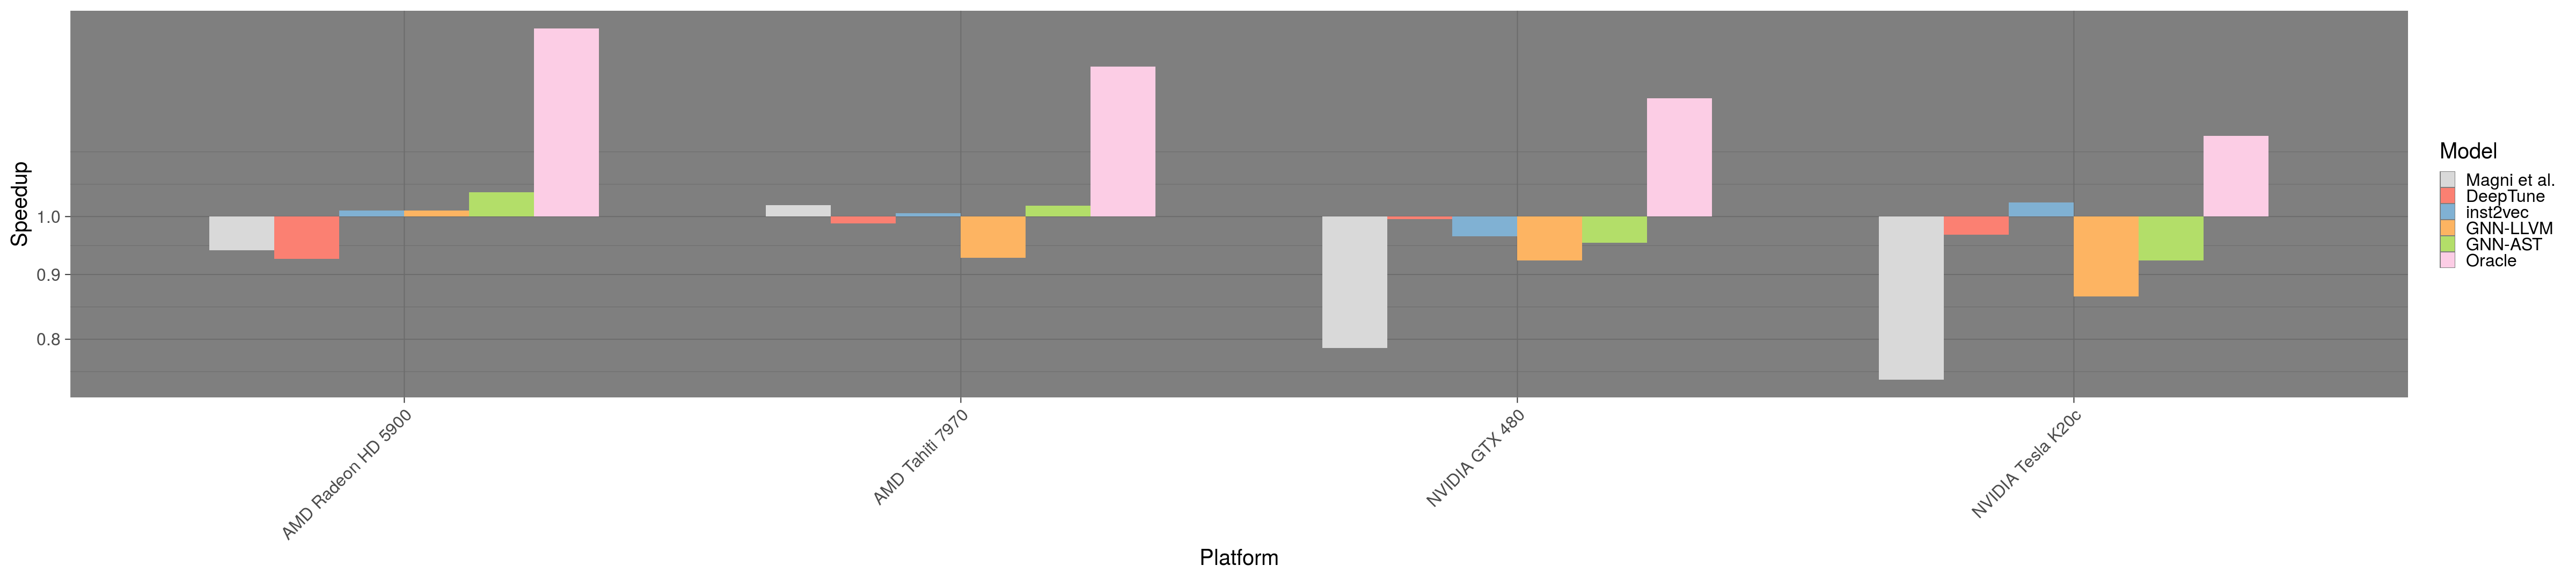

In [45]:
ggplot(data = tc_with_oracles) +
      geom_col(width=0.7,position='dodge',mapping = aes(x=`Platform`,y=Speedup,fill=Model)) +
      scale_fill_manual(values = brewer.pal(n = 9, name = "Set3")[c(9,4,5,6,7,8)]) +
      scale_y_log10() +
      theme_dark(base_size = 24) +
      theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
options(repr.plot.width=30, repr.plot.height=9)

## References<a name="refs"></a>

[1] Cummins, Chris, et al. "End-to-end deep learning of optimization heuristics." 2017 26th International Conference on Parallel Architectures and Compilation Techniques (PACT). IEEE, 2017.